In [1]:
%load_ext rpy2.ipython
%matplotlib inline

from prophet import Prophet
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import logging
import warnings

logging.getLogger('prophet').setLevel(logging.ERROR)
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv')
df = df.loc[:180,]  # Limit to first six months
m = Prophet()
m.fit(df)
future = m.make_future_dataframe(periods=60)

Initial log joint probability = -2.39253
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       469.105      0.013332       95.9824           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104       469.378    0.00188999       58.6155   2.721e-05       0.001      161  LS failed, Hessian reset 
     138        469.52    0.00051747       57.5083   5.563e-06       0.001      239  LS failed, Hessian reset 
     183       469.536   1.64602e-06       84.9638   2.312e-08       0.001      336  LS failed, Hessian reset 
     199       469.536   2.55917e-08        79.238      0.2773           1      358   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     201       469.536   5.76571e-09       53.5769      0.2101      0.2101      361   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was 

By default Prophet will return uncertainty intervals for the forecast `yhat`. There are several important assumptions behind these uncertainty intervals.

There are three sources of uncertainty in the forecast: uncertainty in the trend, uncertainty in the seasonality estimates, and additional observation noise.

### Uncertainty in the trend
The biggest source of uncertainty in the forecast is the potential for future trend changes. The time series we have seen already in this documentation show clear trend changes in the history. Prophet is able to detect and fit these, but what trend changes should we expect moving forward? It's impossible to know for sure, so we do the most reasonable thing we can, and we assume that the *future will see similar trend changes as the history*. In particular, we assume that the average frequency and magnitude of trend changes in the future will be the same as that which we observe in the history. We project these trend changes forward and by computing their distribution we obtain uncertainty intervals.

One property of this way of measuring uncertainty is that allowing higher flexibility in the rate, by increasing `changepoint_prior_scale`, will increase the forecast uncertainty. This is because if we model more rate changes in the history then we will expect more in the future, and makes the uncertainty intervals a useful indicator of overfitting.

The width of the uncertainty intervals (by default 80%) can be set using the parameter `interval_width`:

In [3]:
forecast = Prophet(interval_width=0.95).fit(df).predict(future)

Initial log joint probability = -2.39253
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       469.105      0.013332       95.9824           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104       469.378    0.00188999       58.6155   2.721e-05       0.001      161  LS failed, Hessian reset 
     138        469.52    0.00051747       57.5083   5.563e-06       0.001      239  LS failed, Hessian reset 
     183       469.536   1.64602e-06       84.9638   2.312e-08       0.001      336  LS failed, Hessian reset 
     199       469.536   2.55917e-08        79.238      0.2773           1      358   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     201       469.536   5.76571e-09       53.5769      0.2101      0.2101      361   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was 

Again, these intervals assume that the future will see the same frequency and magnitude of rate changes as the past. This assumption is probably not true, so you should not expect to get accurate coverage on these uncertainty intervals.

### Uncertainty in seasonality
By default Prophet will only return uncertainty in the trend and observation noise. To get uncertainty in seasonality, you must do full Bayesian sampling. This is done using the parameter `mcmc.samples` (which defaults to 0). We do this here for the first six months of the Peyton Manning data from the Quickstart:

In [5]:
m = Prophet(mcmc_samples=300)
forecast = m.fit(df).predict(future)

Process SpawnPoolWorker-3:
Traceback (most recent call last):
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.8/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.8/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.8/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.8/lib/python3.8/multiprocessing/queues.py", line 358, in get
    return _ForkingPickler.loads(res)
ModuleNotFoundError: No module named 'stanfit4anon_model_dfdaf2b8ece8a02eb11f050ec701c0ec_580956811916159043'
Process SpawnPoolWorker-4:
Process SpawnPoolWorker-1:
Process SpawnPoolWorker-2:
Traceback

This replaces the typical MAP estimation with MCMC sampling, and can take much longer depending on how many observations there are - expect several minutes instead of several seconds. If you do full sampling, then you will see the uncertainty in seasonal components when you plot them:

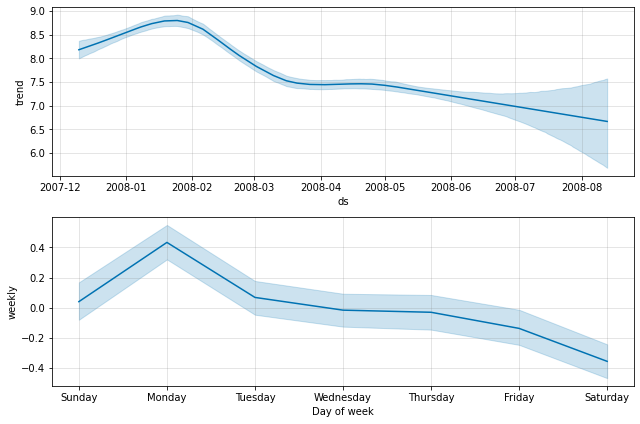

In [ ]:
fig = m.plot_components(forecast)

You can access the raw posterior predictive samples in Python using the method `m.predictive_samples(future)`, or in R using the function `predictive_samples(m, future)`.